## Plot temperature records in Munich for 5 years (2012-2016) and days in 2017 that broke these records with matplotlib

Temperature data was extracted with **Dark Sky API**: https://darksky.net/dev <br>
Total number of rows: 2193 <br>
City to analyze: Munich <br>
Date range: 2012-2017

### The plot looks like this:

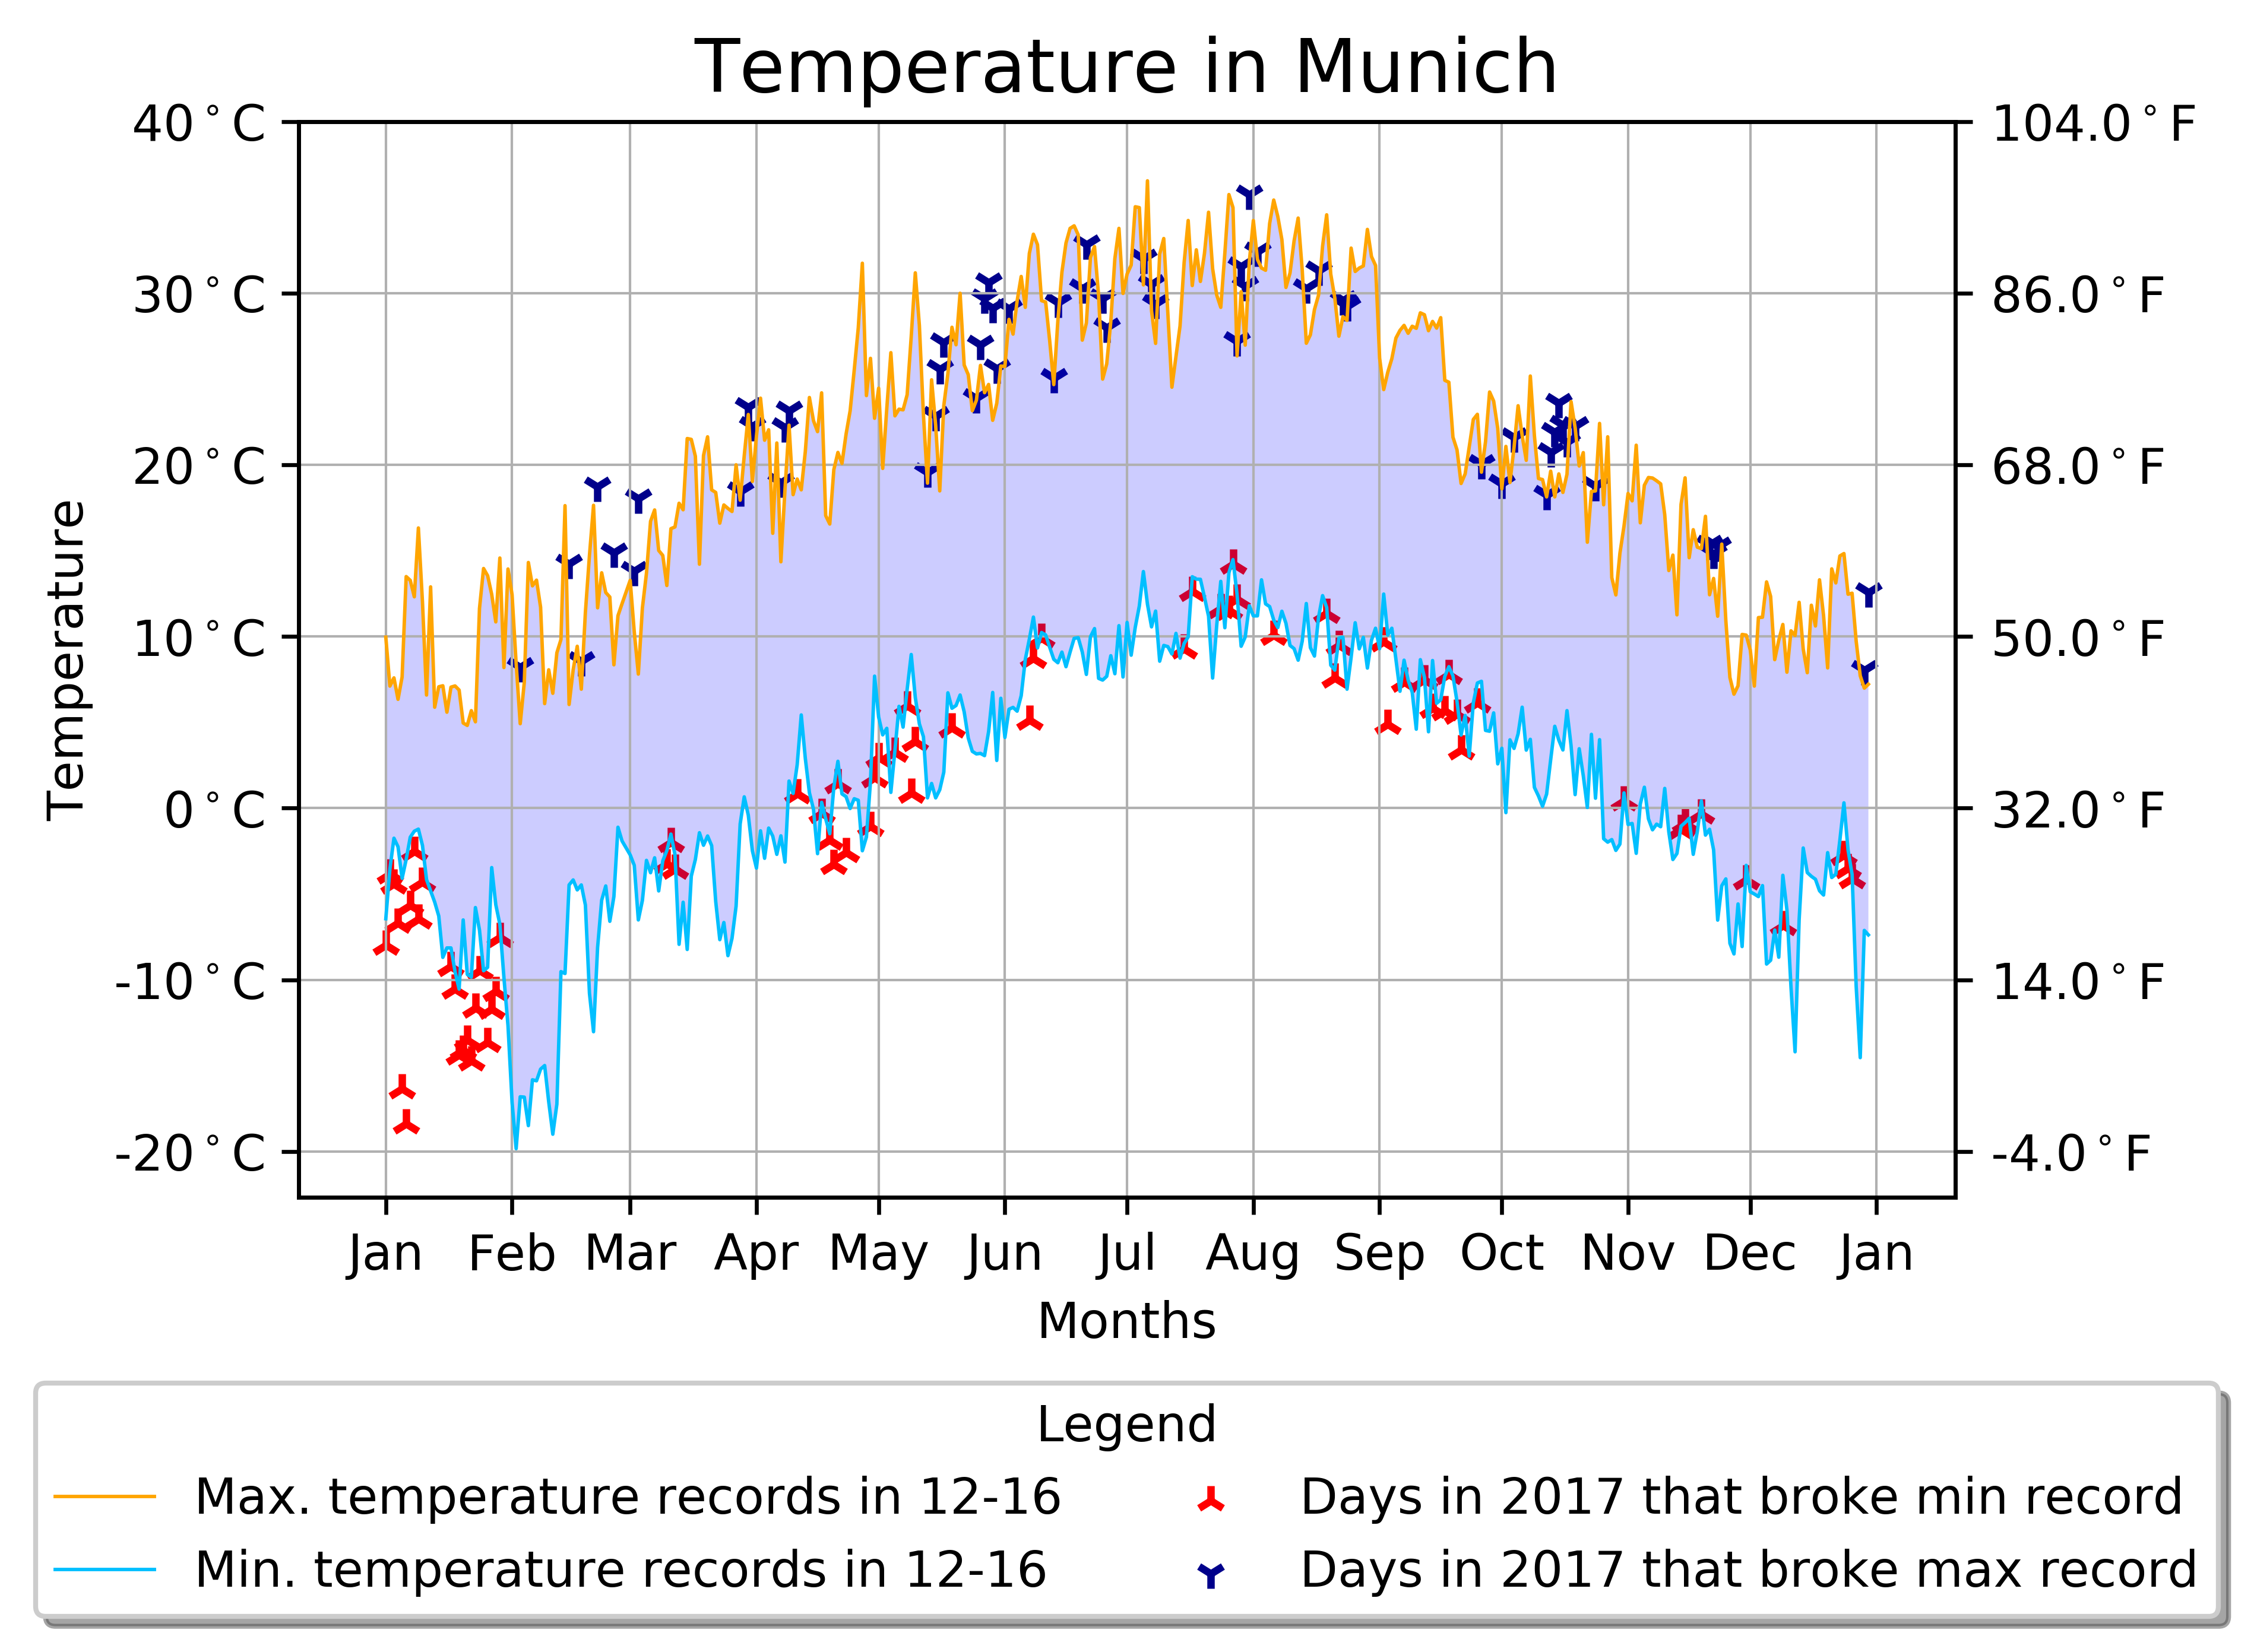

In [8]:
from IPython.display import Image
Image(filename='munich.png')

## The code to create this plot

**Data extraction**

Extracting historical weather data from darksky api; 
Data is stored in JSON format for further processing

In [ ]:
import requests
import time
import os
import json

#create file to put info in
with open(os.path.join("D:/weather_matplotlib/", "data_.json"), 'w'):
    pass

#API parameters
params = (
    ('exclude', 'currently,flags,minutely,hourly,alerts'),
    ('units', 'si'),
)

API_key = '[Insert API key]'
timestamp = 1388271600 #31.12.12 - unix

lat = '48.135125'
lon = '11.581980'
day_num =  365*6 #(6 years)

for i in range(day_num):
    print("Iteration: "+str(i))
    request = 'https://api.darksky.net/forecast/'+API_key+'/'+lat+','+lon+','+ str(timestamp)
    response = requests.get(request, params=params)
    data = response.json()
    with open("D:/weather_matplotlib/data_.json", 'a') as f:
        f.write(json.dumps(data['daily']['data'][0]))
        f.write("\n")
    timestamp = timestamp + 86400  #adds one day to a timestamp
    #if i % 5 == 0: #making a pause for 3 seconds every 5th day
        #time.sleep(2)
f.close() 

**Import data**

In [9]:
import pandas as pd
import numpy as np

df = pd.read_json("data_.json", lines=True)
df = df[["time", "apparentTemperatureMax", "apparentTemperatureMin"]]

**Convert unix to datetime**

In [10]:
from datetime import datetime
df["datetime"] = pd.to_datetime(df['time'],unit='s').dt.date #leave only date, remove time

**Extract year, month and day from date**

In [11]:
df["year"] = pd.DatetimeIndex(df['datetime']).year
df["month"] = pd.DatetimeIndex(df['datetime']).month
df["day"] = pd.DatetimeIndex(df['datetime']).day

**Divide the datadrame in two, one contains data from 2012 to 2016, the second contains data from 2017**

In [12]:
df_12_16 =  df.drop(df[df["year"] == 2017].index)
df_17 =  df.drop(df[df["year"] != 2017].index)

**Apply groupby to calculate max and min temperature of years 2012-2016**

In [13]:
df_groupped_min = df_12_16.groupby(['month', 'day'])[["apparentTemperatureMin"]].min().reset_index()
df_groupped_max = df_12_16.groupby(['month', 'day'])[["apparentTemperatureMax"]].max().reset_index()

**Merge month and day in one column**

In [14]:
df_groupped_min["date"] = df_groupped_min["month"].map(str) + "/" + df_groupped_min["day"].map(str)
df_groupped_max["date"] = df_groupped_max["month"].map(str) + "/" + df_groupped_max["day"].map(str) 

**Drop useless columns**

In [15]:
df_groupped_min = df_groupped_min[["date","apparentTemperatureMin"]]
df_groupped_max = df_groupped_max[["date","apparentTemperatureMax"]]

**Merge columns with min and max values of years 2012-2016**

In [16]:
merged_df=pd.merge(df_groupped_min, df_groupped_max, how='inner', left_on='date', right_on='date')
merged_df = merged_df.rename(index=str, columns={"apparentTemperatureMin": "min_12_16", "apparentTemperatureMax": "max_12_16"})

**Dataframe with values of the year 2017 is processed**

In [17]:
df_17["date"] = df_17["month"].map(str) + "/" + df_17["day"].map(str) 
df_17 = df_17[["date","apparentTemperatureMin","apparentTemperatureMax"]]
df_17 = df_17.rename(index=str, columns={"apparentTemperatureMin": "min_17", "apparentTemperatureMax": "max_17"})

**Merge dataframes of years 2012-16 with data from 2017**

In [18]:
df_fin=pd.merge(df_17, merged_df, how='inner', left_on='date', right_on='date')

**Add some random year (this step is required to plot data)**

In [19]:
df_fin["date"] = df_fin["date"].map(str) + "/" + "2000"
df_fin['date'] = pd.to_datetime(df_fin['date'])

**Create boolen variable that indicates either temperature from year 2017 broke record or not**

In [20]:
df_fin['max_overcame'] = np.where(df_fin['max_17']>df_fin["max_12_16"], 'true', 'false')
df_fin['min_overcame'] = np.where(df_fin['min_17']<df_fin["min_12_16"], 'true', 'false')

**Variables to create scatterplots later**

In [22]:
df_min_o = df_fin.loc[df_fin['min_overcame'] == 'true'][["date","min_17"]]
df_max_o = df_fin.loc[df_fin['max_overcame'] == 'true'][["date","max_17"]]

**Plot the data**

[Text(1,0,'-4.0$^\\circ$F'),
 Text(1,0,'14.0$^\\circ$F'),
 Text(1,0,'32.0$^\\circ$F'),
 Text(1,0,'50.0$^\\circ$F'),
 Text(1,0,'68.0$^\\circ$F'),
 Text(1,0,'86.0$^\\circ$F'),
 Text(1,0,'104.0$^\\circ$F')]

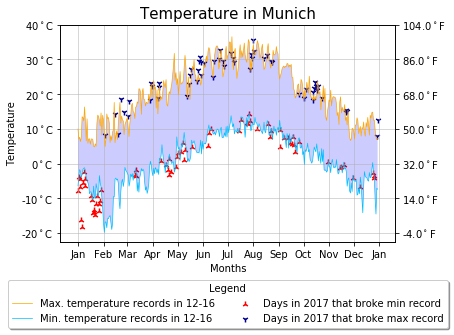

In [23]:
import matplotlib.pyplot as plt

#scatterplot needs lists
plt.plot(df_fin["date"], df_fin["max_12_16"], linestyle='-', color='orange', linewidth=0.7, label='Max. temperature records in 12-16')
plt.plot(df_fin["date"], df_fin["min_12_16"], linestyle='-', color='deepskyblue', linewidth=0.7, label='Min. temperature records in 12-16')
plt.scatter(df_min_o["date"].tolist(), df_min_o['min_17'], marker ='2', c='red', label='Days in 2017 that broke min record')
plt.scatter(df_max_o["date"].tolist(), df_max_o['max_17'], marker ='1', c='darkblue', label='Days in 2017 that broke max record')
plt.title('Temperature in Munich', fontsize=15)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2, title='Legend')


import matplotlib.dates as mdates
maxv=df_fin['max_12_16']
minv=df_fin['min_12_16']

#show only months
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
monthFmt = mdates.DateFormatter('%b')
ax.xaxis.set_major_formatter(monthFmt)
plt.xlabel('Months')

#add grid and filling betwees min and max values
d = df_fin['date'].values
plt.gca().fill_between(d, minv, maxv, facecolor='blue', alpha=0.2)
ax.grid(True, linewidth=0.5)

##add celsius
ax.set_yticks(np.arange(-20,50,10)) #ads numbers to y axis
ax.set_yticklabels(str(i)+'$^\circ$C' for i in np.arange(-20,50,10)) #ads Celsium symbol
plt.ylabel('Temperature')

##add fahrenheit
ax1=ax.twinx()
ax1.set_yticks(ax.get_yticks())
ax1.set_ylim(ax.get_ylim())
ax1.set_yticklabels(map(lambda x : '{:}'.format((x*1.8)+32)+'$^\circ$F', ax1.get_yticks()))

**Save plot**

In [ ]:
plt.savefig('munich.png', bbox_inches='tight',dpi = 600)